## Import Library

In [22]:
!pip install transformers

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import glob
import shutil
import random
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import get_cosine_schedule_with_warmup
from transformers import SegformerForSemanticSegmentation

## Class Dataset

In [24]:
class BreastCancerDataset(Dataset):
    def __init__(self, root='/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT', is_train=True, transform=None):
        self.categories = ["benign", "malignant", "normal"]
        self.transform = transform
        self.path = glob.glob("{}/*/*_mask.png".format(root))

        random.seed(159)
        random.shuffle(self.path)
        if is_train:
            self.path = self.path[:int(len(self.path) * 0.85)]
        else:
            self.path = self.path[int(len(self.path) * 0.85):]
    
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, index):
        image = cv2.imread(self.path[index].replace("_mask.png", ".png"))
        mask = cv2.imread(self.path[index], cv2.IMREAD_GRAYSCALE)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask[mask == 255] = 1

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        return image.float(), mask.float()

In [25]:
size = 512
train_transform = A.Compose([
    A.Resize(size, size),
    # A.RandomRotate90(),
    # A.GaussianBlur(),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    # A.CoarseDropout(max_height=25, max_width=25, fill_value=255),
    # A.ElasticTransform(alpha=1.0),
    A.HorizontalFlip(),
    A.Perspective(scale=(0.05, 0.1)),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

## UnNormalized

In [26]:
class UnNormalized(object):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unNorm = UnNormalized()

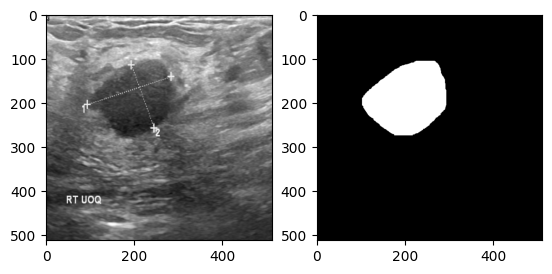

In [27]:
train_dataset = BreastCancerDataset(transform=train_transform)
test_dataset = BreastCancerDataset(is_train=False, transform=test_transform)

image, mask = train_dataset[random.randint(1, len(train_dataset))]
plt.subplot(1, 2, 1)
plt.imshow(unNorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

## AverageMeter

In [28]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n = 1):
        self.val += val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Show Loss

In [29]:
def plot_segmentation_metrics(train_loss, val_loss, train_mean_iou=None, val_mean_iou=None, 
                              train_dice_score=None, val_dice_score=None):
    """
    Plot training and validation metrics (loss, mean IoU, Dice score) over epochs.

    Args:
    - train_loss (list): List of training loss values over epochs.
    - val_loss (list): List of validation loss values over epochs.
    - train_mean_iou (list, optional): List of training mean IoU values over epochs.
    - val_mean_iou (list, optional): List of validation mean IoU values over epochs.
    - train_dice_score (list, optional): List of training Dice score values over epochs.
    - val_dice_score (list, optional): List of validation Dice score values over epochs.
    """
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plotting the Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Val Loss')
    plt.title('Training and Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting the Mean IoU (if available)
    if train_mean_iou and val_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_mean_iou, 'r', label='Training Mean IoU')
        plt.plot(epochs, val_mean_iou, 'b', label='Val Mean IoU')
        plt.title('Training and Test Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Plotting the Dice Score (if available)
    if train_dice_score and val_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_dice_score, 'r', label='Training Dice Score')
        plt.plot(epochs, val_dice_score, 'b', label='Test Dice Score')
        plt.title('Training and Test Dice Score')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

## Calculate Intersection And Union

In [30]:
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

## Train

In [31]:
upsample = nn.Upsample(scale_factor=4, mode='bilinear')

In [32]:
def train(num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    train_dataset = BreastCancerDataset(transform=train_transform)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_workers
    )
    
    test_dataset = BreastCancerDataset(is_train=False, transform=test_transform)
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        num_workers=n_workers
    )

    version = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(version)
    
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
    model.to(device)
    
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=1e-4)
    
    num_epoch = len(train_loader)
    
    scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=num_epoch*epochs, power=0.9)

    
    if os.path.isdir(checkpoint):
        shutil.rmtree(checkpoint)
    os.makedirs(checkpoint)
    
    if not os.path.isdir(saved_model):
        os.makedirs(saved_model)
    
    writer = SummaryWriter(checkpoint)
    
    train_loss = []
    test_loss = []
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    train_loss_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    
    no_improvement_counter = 0
    patience = 10
    best_mIoU = -1
    
    for epoch in range(epochs):
        model.train()
        train_loss_meter.reset()
        test_loss_meter.reset()
        intersection_meter.reset()
        union_meter.reset()
        
        progress_bar = tqdm(train_loader, colour='cyan')
        
        for i, (image, mask) in enumerate(progress_bar):
            image, mask = image.to(device), mask.to(device)
            
            output = model(image).logits
            output = upsample(output).squeeze()
            loss = criterion(output, mask)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_meter.update(loss.item())
            progress_bar.set_description(f"Train | Epoch {epoch + 1}/{epochs} | Loss {train_loss_meter.avg:.4f} | lr {optimizer.param_groups[0]['lr']}")
            writer.add_scalar("Train/Loss AVG", train_loss_meter.avg, num_epoch * epoch + i)
            writer.add_scalar("Train/Loss", loss.item(), num_epoch * epoch + i)
            scheduler.step()
        
        model.eval()
        with torch.no_grad():
            progress_bar = tqdm(iterable=test_loader, colour='yellow')
            
            for image, mask in progress_bar:
                image, mask = image.to(device), mask.to(device)
                
                output = model(image).logits
                output = upsample(output).squeeze()
                loss = criterion(output, mask)
                
                test_loss_meter.update(loss.item())
                output[output>=0.5] = 1
                output[output<0.5] = 0
                output = output.long()
                mask = mask.long()
                
                intersection, union, target = intersectionAndUnionGPU(output, mask, 2)           
                intersection_meter.update(intersection)
                union_meter.update(union)
                
                iou = intersection / (union + 1e-10)
                mean_iou = np.mean(iou.cpu().numpy())
                dice = 2 * intersection / (intersection + union + 1e-10)

                dice_value = dice.mean().item()
                
                intersection_meter.update(intersection)
                union_meter.update(union)
                test_loss_meter.update(loss.item())
                
                progress_bar.set_description(f"Val | Loss {loss.item():.4f} | mIoU: {mean_iou:.4f} | dice: {dice_value:.4f}")
            
            
            iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
            dice_class = 2 * intersection_meter.sum / (intersection_meter.sum + union_meter.sum + 1e-10)
            
            mIoU = iou_class.mean().item()
            mDice = dice_class.mean().item()
            print(f"Val | Loss {test_loss_meter.avg:.4f} | mIoU: {mIoU:.4f} | dice: {mDice:.4f}")
            
            writer.add_scalar("Val/Loss", test_loss_meter.avg, epoch)
            writer.add_scalar("Val/mIoU", mIoU, epoch)
            writer.add_scalar("Val/dice", mDice, epoch)
            
            checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch + 1,
                "mIoU": mIoU
            }
            
            torch.save(checkpoint, os.path.join(saved_model, "last.pt"))
            
            if mIoU > best_mIoU:
                best_mIoU = mIoU
                torch.save(checkpoint, os.path.join(saved_model, "best.pt"))
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1
              
            train_loss.append(train_loss_meter.avg)
            test_loss.append(test_loss_meter.avg)
            
            if no_improvement_counter > patience:
                print("Early stopping!")
                break
    
    plot_segmentation_metrics(train_loss, test_loss)


In [33]:
torch.cuda.empty_cache()

In [ ]:
num_class = 1
n_workers = os.cpu_count()
print(n_workers)
batch_size = 16
lr = 1e-4
epochs = 50
checkpoint = "/kaggle/working/tensorboard"
saved_model = "/kaggle/working/saved_model"

train(num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model)

4


  0%|          | 0/42 [00:01<?, ?it/s]


## Inference

In [ ]:
def pred_show_image_grid(model_pth, device, test_dataset, num_classes, idx, num_imgs):
    # Load model checkpoint
    checkpoint = torch.load(model_pth)
    
    # Initialize and load model state
    model_name = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(model_name)
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
    model.to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    # Load validation dataset
    
    images, orig_masks, pred_masks = [], [], []
    
    with torch.no_grad():
        for i in idx:
            ori_img, orig_mask = test_dataset[i]
            img = ori_img

            # Predict mask
            img = img.float().to(device).unsqueeze(0)
            # (B, 21, H, W) -> (B, 1, H, W) -> (B, H, W)
            pred_mask = upsample(model(img).logits).squeeze()
            pred_mask[pred_mask>=0.5] = 1
            pred_mask[pred_mask<0.5] = 0
            pred_mask = pred_mask.long().cpu().numpy()

            images.append(unNorm(ori_img).permute(1, 2, 0))
            orig_masks.append(orig_mask)
            pred_masks.append(pred_mask)

    
    # Combine images and masks for display
    images.extend(orig_masks)
    images.extend(pred_masks)
    
    # Plot images and masks
    fig = plt.figure(figsize=(20, 10))
    for i in range(1, 3*num_imgs + 1):
        fig.add_subplot(3, num_imgs, i)
        plt.imshow(images[i - 1], cmap='gray')
    plt.show()

In [ ]:
#Note: You must train the model before using this param
model_pth = "/kaggle/working/saved_model/best.pt"
num_classes = 1
device = "cuda" if torch.cuda.is_available() else "cpu" 
print("\n")
indexs = random.sample(range(len(test_dataset)), 8)
print("indexs =", indexs)
print("\n")

#Show images
pred_show_image_grid(model_pth, device, test_dataset, num_classes, indexs, num_imgs= 8)